<a href="https://colab.research.google.com/github/econdatatech/GISC420/blob/main/GISC_420_Mini_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### GISC 420 T1 2022
# Mini Project Part 2


Corvin Idler,  ID 300598312 

While in the first notebook I managed to plot flows on a basic slippy map, the result wasn't really interactive apart from zooming and panning functionality.

A feature request for adding a tool tip functionality to mplleaflet is still open since several years: https://github.com/jwass/mplleaflet/issues/27

So we are still left with looking for options to make the map interactive while maintaining a high level of control over visual aspects of the flows.

The general problem is, that one can often draw an arbitrary number of basic graphical primitives like line segments on a map and usually has control over their individual color and width, but one wants these elements to behave like one unit or collection (like a LineCollection or a Polygon) e.g. for mouse over or tooltip activities.

One can draw variable width lines or equivalent polygons in several ways and in the R ecosystem good documentation exists:
https://rdrr.io/github/houyunhuang/ggvwline/src/R/geom-vwline.R

https://rdrr.io/github/houyunhuang/ggvwline/src/R/geom-vwcurve.R

https://www.stat.auckland.ac.nz/~paul/Reports/VWline/vwline-intro/power-curve.html#Resources

One can create polygons with color gradients in matplotlib by creating a color gradient canvas and then define a polygon that is used as a clipping mask. E.g.
https://www.pythonfixing.com/2022/05/fixed-fill-polygon-with-vertical.html or https://stackoverflow.com/questions/25701321/how-to-use-set-clipped-path-for-basemap-polygon. 

Unfortunately mplleaflet doesn't support this type of figure to be drawn on a leaflet slippy map. I therefore decided to abandon the matplotlib/mplleaflet route and looked instead more into drawing in Folium without going via matplotlib.

#ETL
Then we just use the data wrangling results from the first notebook. No need to repeat the whole data wrangling again.

In [1]:
!pip install geopandas
!pip install  pyproj

import re,requests
import geopandas as gpd
from io import BytesIO

#just getting the data from my github repository
exports_geo=gpd.read_parquet(BytesIO(requests.get('https://github.com/econdatatech/GISC420/blob/main/nzexports_geo.parquet?raw=true', allow_redirects=True).content))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 276 kB/s 
     |████████████████████████████████| 6.3 MB 40.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Encouraged by this notebook https://colab.research.google.com/github/kburchfiel/route_maps_builder/blob/master/route_maps_builder_v2.ipynb I wanted to try recreating a similar map result as I had with mplleaflet but without going via matplotlib. 

The two main things missing is the colour gradient and the variable line width.
There is a ColorLine class in Folium that would facilitate a colour gradient, but it doesn't allow for a tooltip functionality.

The variable line width would require me to draw (again) very tiny line segments with increasing width. 



In [2]:
import folium
import math
import pyproj
from pyproj import Proj, transform
import numpy as np

def create_geodesic_line(start_point, end_point, tolerance=1000):
    start_x, start_y = start_point
    end_x, end_y = end_point
    g = pyproj.Geod(ellps='WGS84')
    az12, az21, dist = g.inv(start_x, start_y, end_x, end_y)
    coords = g.npts(start_x, start_y, end_x, end_y, 1 + int(dist / tolerance))
    coords.insert(0, (start_x, start_y))
    coords.append((end_x, end_y))
    return zip(*coords)

exports_geo.set_crs('EPSG:3857')
df=exports_geo.loc[exports_geo['Year']=='2018',:]
df.loc[:,'Exports ($NZD fob)']=round(df['Exports ($NZD fob)']/1000000,2)
df.rename(columns = {'Exports ($NZD fob)':'Exports'}, inplace = True)
df['width'] = df.apply(lambda x:  math.ceil(x.Exports/500), axis=1)
df.sort_values('Exports', ascending=False,axis=0,inplace=True)

test_map = folium.Map(location=[-40,170-360], zoom_start=2)
fg = folium.FeatureGroup("Lines")


for index, export in df.head(30).iterrows():
  if export.geometry.x >-5:  
    xs, ys = create_geodesic_line((174.885971-360,-40.900557),(export.geometry.x-360,export.geometry.y), tolerance=100000)
  else:
    xs, ys = create_geodesic_line((174.885971-360,-40.900557),(export.geometry.x,export.geometry.y), tolerance=100000)

  revised_gc_points = []
  for item in zip(xs,ys):
    if item[0] > -5:
      new_lon = item[0] - 360
    else:
      new_lon = item[0]
    revised_gc_points.append((item[1], new_lon))

  folium.PolyLine(revised_gc_points,color='blue',weight=export.width,tooltip='Exports to '+export.Country+' are '+str(round(export.Exports,2))+' million NZD',opacity=1.1/np.sqrt(export.width)).add_to(test_map)


folium.LayerControl(position='bottomright').add_to(test_map)
test_map


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

#Folium - Raster polygon
The other option I tried and came across is to draw a raster polygon with a gradient fill in PIL.ImageDraw. 

That worked in a way (as I could get a colour gradient going and a tool tip that would display information). 

I simply ran out of time to draw the propper swoof / arrow polygons one would want on the map (representing the trade flows). 

So it's more of a proof of concept.

One thing can be seen as a bug or a feature: When zooming into the map, the polygon gets magnified as well (as expected). Maybe for some scenarios one would actually prefer the polygon size to stay the same, but it didn't mind that is gets magnified together with the rest of the map.



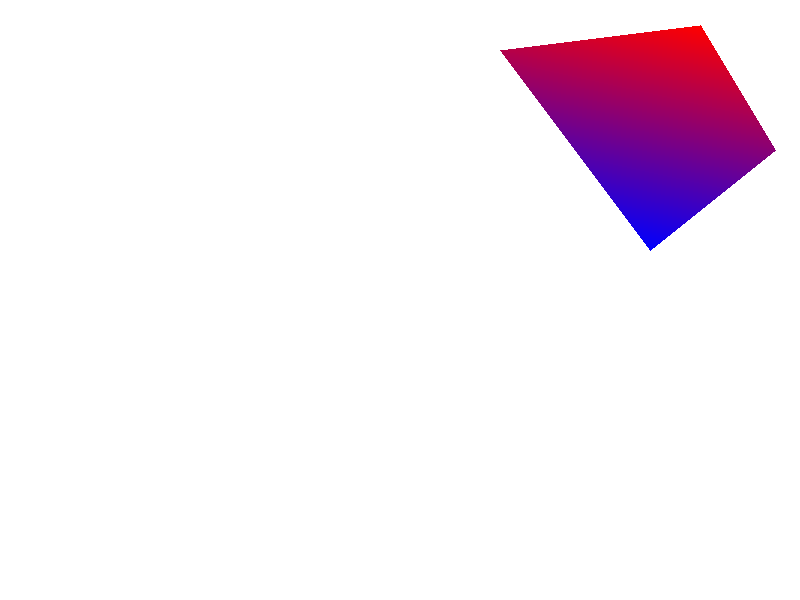
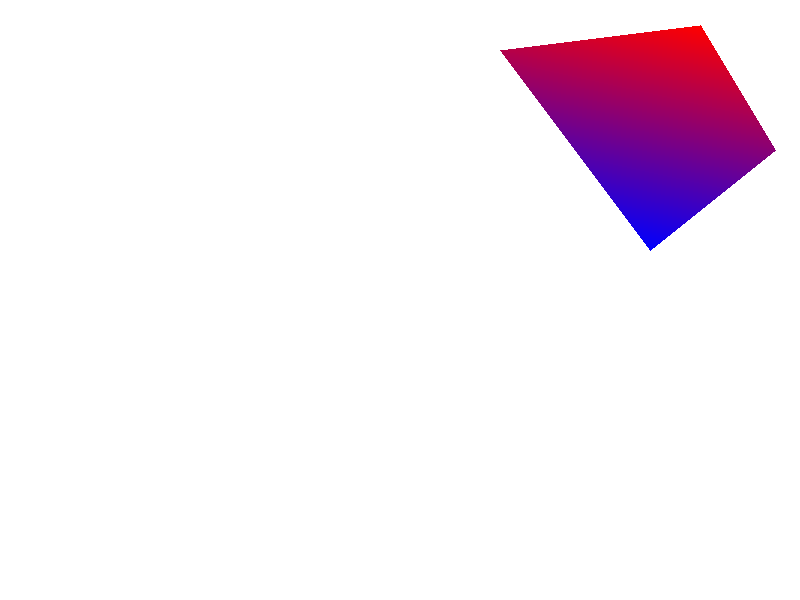

In [3]:
m = folium.Map(location=[0, -90], zoom_start=4)


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
#https://stackoverflow.com/questions/66837477/pillow-how-to-gradient-fill-drawn-shapes

# Draw polygon with linear gradient from point 1 to point 2 and ranging
# from color 1 to color 2 on given image
def linear_gradient(i, poly, p1, p2, c1, c2):

    # Draw initial polygon, alpha channel only, on an empty canvas of image size
    ii = Image.new('RGBA', i.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(ii)
    draw.polygon(poly, fill=(0, 0, 0, 255), outline=None)

    # Calculate angle between point 1 and 2
    p1 = np.array(p1)
    p2 = np.array(p2)
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) / np.pi * 180

    # Rotate and crop shape
    temp = ii.rotate(angle, expand=True)
    temp = temp.crop(temp.getbbox())
    wt, ht = temp.size

    # Create gradient from color 1 to 2 of appropriate size
    gradient = np.linspace(c1, c2, wt, True).astype(np.uint8)
    gradient = np.tile(gradient, [2 * h, 1, 1])
    gradient = Image.fromarray(gradient)

    # Paste gradient on blank canvas of sufficient size
    temp = Image.new('RGBA', (max(i.size[0], gradient.size[0]),
                              max(i.size[1], gradient.size[1])), (0, 0, 0, 0))
    temp.paste(gradient)
    gradient = temp

    # Rotate and translate gradient appropriately
    x = np.sin(angle * np.pi / 180) * ht
    y = np.cos(angle * np.pi / 180) * ht
    gradient = gradient.rotate(-angle, center=(0, 0),
                               translate=(p1[0] + x, p1[1] - y))

    # Paste gradient on temporary image
    ii.paste(gradient.crop((0, 0, ii.size[0], ii.size[1])), mask=ii)

    # Paste temporary image on actual image
    i.paste(ii, mask=ii)

    return i


# Create blank canvas with zero alpha channel
w, h = (800, 600)
image = Image.new('RGBA', (w, h), (0, 0, 0, 0))


# Draw polygon with linear gradient
polygon = [(500, 50), (650, 250), (775, 150), (700, 25)]
point1 = (700, 25)
point2 = (650, 250)
color1 = (255, 0, 0)
color2 = (0, 0, 255)
image = linear_gradient(image, polygon, point1, point2, color1, color2)

image.save("py.png", "PNG")

image = folium.raster_layers.ImageOverlay(image='/content/py.png',bounds=[[22, -100], [26, -105]],interactive=True,opacity=0.7)

image1 = folium.raster_layers.ImageOverlay(image='/content/py.png',bounds=[[21, -112], [26, -119]],interactive=True,opacity=0.7)


folium.Tooltip("I am an image").add_to(image)
folium.Tooltip("I am more of an image").add_to(image1)

image.add_to(m)
image1.add_to(m)


folium.LayerControl(collapsed=False).add_to(m)



m